# Fairness Analysis & Mitigation - Phase 6

**Project**: Loan Approval Decision Support System  
**Phase**: 6 - Fairness Analysis & Mitigation  
**Date**: February 15, 2026

## Objectives

This notebook implements comprehensive fairness analysis and bias mitigation:

1. **Calculate Fairness Metrics**: DPD, EOD, and 80% Rule for all models
2. **Compare Model Fairness**: Evaluate which models are most fair across demographics
3. **Bias Detection**: Identify features contributing to bias using SHAP
4. **Bias Mitigation**: Apply pre/in/post-processing techniques
5. **Validate Results**: Ensure fairness criteria met (DPD/EOD < 0.05)
6. **Trade-off Analysis**: Balance fairness vs accuracy

## Fairness Criteria

- **Demographic Parity Difference (DPD)**: < 0.05
- **Equalized Odds Difference (EOD)**: < 0.05  
- **80% Rule (Disparate Impact)**: Pass (≥ 0.80)

---

In [42]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import KBinsDiscretizer

# Fairness libraries
try:
    from fairlearn.metrics import (
        demographic_parity_difference,
        demographic_parity_ratio,
        equalized_odds_difference,
        MetricFrame
    )
    print("✅ Fairlearn installed")
except ImportError:
    print("⚠️  Fairlearn not installed. Install with: pip install fairlearn")

# SHAP for interpretability
try:
    import shap
    print("✅ SHAP installed")
except ImportError:
    print("⚠️  SHAP not installed. Install with: pip install shap")

# GOSDT (Interpretable Decision Trees)
try:
    from gosdt import GOSDT
    GOSDT_AVAILABLE = True
    print("✅ GOSDT installed")
except ImportError:
    GOSDT_AVAILABLE = False
    print("⚠️  GOSDT not installed. Install with: pip install gosdt")

# FasterRisk (Interpretable Risk Score Model)
try:
    from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier
    FASTERRISK_AVAILABLE = True
    print("✅ FasterRisk installed")
except ImportError:
    FASTERRISK_AVAILABLE = False
    print("⚠️  FasterRisk not installed. Install with: pip install fasterrisk")

# XGBoost
import xgboost as xgb

# TensorFlow
import tensorflow as tf
from tensorflow import keras

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("\n✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

✅ Fairlearn installed
✅ SHAP installed
✅ GOSDT installed
✅ FasterRisk installed

✅ Libraries imported successfully
TensorFlow version: 2.13.1


In [48]:
# ============================================================================
# SET WORKING DIRECTORY
# ============================================================================
import os

# Set working directory to project root
project_root = Path('/Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval')
os.chdir(project_root)

print("="*80)
print("WORKING DIRECTORY VERIFICATION")
print("="*80)
print(f"Current working directory: {os.getcwd()}")
print(f"✅ Working directory set to project root")

WORKING DIRECTORY VERIFICATION
Current working directory: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval
✅ Working directory set to project root


## 1. Load Models and Data

Load all trained models and test data with protected attributes for fairness analysis.

In [49]:
# ============================================================================
# LOAD SAVED MODELS
# ============================================================================

print("="*80)
print("LOADING TRAINED MODELS")
print("="*80)

models_dir = Path('models')

# Load models
print("\nLoading models...")
try:
    lr_model = joblib.load(models_dir / 'baseline_logistic.pkl')
    print("✓ Logistic Regression loaded")
except:
    print("⚠ Logistic Regression not found")
    lr_model = None

try:
    xgb_model = joblib.load(models_dir / 'xgboost_model.pkl')
    print("✓ XGBoost loaded")
except:
    print("⚠ XGBoost not found")
    xgb_model = None

try:
    rf_model = joblib.load(models_dir / 'random_forest_model.pkl')
    print("✓ Random Forest loaded")
except:
    print("⚠ Random Forest not found")
    rf_model = None

try:
    nn_model = keras.models.load_model(models_dir / 'neural_network_model.keras')
    print("✓ Neural Network loaded")
except:
    print("⚠ Neural Network not found")
    nn_model = None

try:
    glm_model = joblib.load(models_dir / 'glm_model.pkl')
    print("✓ GLM loaded")
except:
    print("⚠ GLM not found")
    glm_model = None

# Load GOSDT model (if available)
gosdt_model = None
gosdt_discretizer = None
if GOSDT_AVAILABLE:
    try:
        gosdt_model = joblib.load(models_dir / 'gosdt_model.pkl')
        print("✓ GOSDT loaded")
        try:
            gosdt_discretizer = joblib.load(models_dir / 'gosdt_discretizer.pkl')
            print("✓ GOSDT discretizer loaded")
        except:
            print("⚠ GOSDT discretizer not found")
    except:
        print("⚠ GOSDT not found - will skip in analysis")

# Load FasterRisk model (if available)
fasterrisk_model = None
fasterrisk_discretizer = None
if FASTERRISK_AVAILABLE:
    try:
        fasterrisk_model = joblib.load(models_dir / 'fasterrisk_model.pkl')
        print("✓ FasterRisk loaded")
        try:
            fasterrisk_discretizer = joblib.load(models_dir / 'fasterrisk_discretizer.pkl')
            print("✓ FasterRisk discretizer loaded")
        except:
            # May share discretizer with GOSDT
            if gosdt_discretizer is not None:
                fasterrisk_discretizer = gosdt_discretizer
                print("✓ FasterRisk using GOSDT discretizer")
    except:
        print("⚠ FasterRisk not found - will skip in analysis")

try:
    scaler = joblib.load(models_dir / 'feature_scaler.pkl')
    print("✓ Feature scaler loaded")
except:
    print("⚠ Feature scaler not found")
    scaler = None

# Load ensemble info
try:
    with open(models_dir / 'ensemble_info.json', 'r') as f:
        ensemble_info = json.load(f)
    print("✓ Ensemble info loaded")
except:
    print("⚠ Ensemble info not found")
    ensemble_info = None

print("\n✅ Models loaded successfully")

LOADING TRAINED MODELS

Loading models...
✓ Logistic Regression loaded
✓ XGBoost loaded
✓ Random Forest loaded
✓ Neural Network loaded
✓ GLM loaded
✓ GOSDT loaded
⚠ GOSDT discretizer not found
✓ FasterRisk loaded
✓ Feature scaler loaded
✓ Ensemble info loaded

✅ Models loaded successfully


In [51]:
# ============================================================================
# LOAD TEST DATA WITH PROTECTED ATTRIBUTES
# ============================================================================

print("\n" + "="*80)
print("LOADING TEST DATA")
print("="*80)

# Load full dataset with protected attributes
data_path = Path('data/processed/feature_engineered_data.csv')
print(f"\nLoading data from: {data_path}")
df_full = pd.read_csv(data_path, low_memory=False)

print(f"Full dataset shape: {df_full.shape}")

# Load test indices or recreate test split
output_dir = Path('data/processed')
try:
    df_test = pd.read_csv(output_dir / 'test.csv') # /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/processed/test.csv
    print(f"✓ Test set loaded: {df_test.shape}")
except:
    print("⚠ Test set not found, will recreate from split")
    df_test = None

# Identify protected attributes
protected_attributes = ['derived_race', 'derived_ethnicity', 'derived_sex']
print(f"\n📋 Protected attributes for fairness analysis:")
for attr in protected_attributes:
    if attr in df_full.columns:
        print(f"   ✓ {attr}: {df_full[attr].nunique()} categories")
    else:
        print(f"   ✗ {attr}: NOT FOUND")

print("\n✅ Data loaded successfully")


LOADING TEST DATA

Loading data from: data/processed/feature_engineered_data.csv


Full dataset shape: (493568, 115)
✓ Test set loaded: (74036, 58)

📋 Protected attributes for fairness analysis:
   ✓ derived_race: 9 categories
   ✓ derived_ethnicity: 5 categories
   ✓ derived_sex: 4 categories

✅ Data loaded successfully


In [52]:
# ============================================================================
# PREPARE TEST DATA FOR FAIRNESS ANALYSIS
# ============================================================================

print("="*80)
print("PREPARING TEST DATA FOR FAIRNESS ANALYSIS")
print("="*80)

# Handle case where df_test is None or doesn't have protected attributes
if df_test is None:
    print("\n⚠ Test set not found, reconstructing from full dataset...")
    # Use the last 15% as test set (matching typical split)
    test_size = int(len(df_full) * 0.15)
    df_test_full = df_full.tail(test_size).copy()
    print(f"✓ Test set reconstructed: {df_test_full.shape}")
    
elif 'derived_race' not in df_test.columns:
    print("\nMerging test data with protected attributes...")
    
    # Load feature engineering info to get modeling features
    feature_info_path = Path('data/processed/feature_engineering_info.json')
    if feature_info_path.exists():
        with open(feature_info_path, 'r') as f:
            feature_info = json.load(f)
        modeling_features = feature_info.get('modeling_features', [])
    else:
        modeling_features = [col for col in df_test.columns if col not in ['target', 'unnamed:_0']]
    
    print("⚠ Note: Reconstructing test set from original data")
    test_size = int(len(df_full) * 0.15)
    df_test_full = df_full.tail(test_size).copy()
    print(f"✓ Test set with protected attributes: {df_test_full.shape}")
else:
    df_test_full = df_test.copy()

# Clean up column names
if 'unnamed:_0' in df_test_full.columns:
    df_test_full = df_test_full.drop(columns=['unnamed:_0'])

# Verify we have protected attributes
missing_attrs = [attr for attr in protected_attributes if attr not in df_test_full.columns]
if missing_attrs:
    print(f"\n⚠ WARNING: Missing protected attributes: {missing_attrs}")
    print("Fairness analysis will be limited")
else:
    print(f"\n✅ All protected attributes present")

print(f"\nTest set for fairness analysis:")
print(f"  Samples: {len(df_test_full):,}")
print(f"  Approval rate: {df_test_full['target'].mean():.2%}")

# Display demographic breakdown
for attr in protected_attributes:
    if attr in df_test_full.columns:
        print(f"\n{attr} distribution:")
        print(df_test_full[attr].value_counts().head())

PREPARING TEST DATA FOR FAIRNESS ANALYSIS

Merging test data with protected attributes...
⚠ Note: Reconstructing test set from original data
✓ Test set with protected attributes: (74035, 115)

✅ All protected attributes present

Test set for fairness analysis:
  Samples: 74,035
  Approval rate: 94.99%

derived_race distribution:
derived_race
White                        50316
Race Not Available           10650
Black or African American     6355
Asian                         3725
Joint                         2198
Name: count, dtype: int64

derived_ethnicity distribution:
derived_ethnicity
Not Hispanic or Latino     51042
Hispanic or Latino         11415
Ethnicity Not Available     8957
Joint                       2619
Free Form Text Only            2
Name: count, dtype: int64

derived_sex distribution:
derived_sex
Joint                28686
Male                 24477
Female               18160
Sex Not Available     2712
Name: count, dtype: int64


## 2. Generate Predictions for All Models

Generate predictions for each model on the test set with protected attributes.

In [53]:
# ============================================================================
# PREPARE FEATURES FOR PREDICTION
# ============================================================================

print("="*80)
print("PREPARING FEATURES FOR PREDICTION")
print("="*80)

# Separate features and target
y_test = df_test_full['target'].values

# Remove protected attributes and target from features
features_to_drop = protected_attributes + ['target', 'unnamed:_0']
features_to_drop = [f for f in features_to_drop if f in df_test_full.columns]

X_test = df_test_full.drop(columns=features_to_drop, errors='ignore')

print(f"\nFeatures for prediction: {X_test.shape[1]} columns")
print(f"Target variable: {len(y_test):,} samples")
print(f"Protected attributes saved separately")

# Get the exact features expected by the scaler
if scaler is not None and hasattr(scaler, 'feature_names_in_'):
    expected_features = scaler.feature_names_in_
    print(f"\n✓ Scaler expects {len(expected_features)} features")
    
    # Identify feature mismatches
    current_features = set(X_test.columns)
    expected_features_set = set(expected_features)
    
    missing_features = expected_features_set - current_features
    extra_features = current_features - expected_features_set
    
    if missing_features:
        print(f"\n⚠️  Missing features (expected by scaler): {len(missing_features)}")
        for feat in list(missing_features)[:5]:
            print(f"    - {feat}")
        if len(missing_features) > 5:
            print(f"    ... and {len(missing_features) - 5} more")
    
    if extra_features:
        print(f"\n⚠️  Extra features (not expected): {len(extra_features)}")
        for feat in list(extra_features)[:5]:
            print(f"    - {feat}")
        if len(extra_features) > 5:
            print(f"    ... and {len(extra_features) - 5} more")
    
    # Align features to match training exactly
    # Keep only common features and add missing ones with zeros
    X_test_aligned = pd.DataFrame(index=X_test.index)
    
    for feat in expected_features:
        if feat in X_test.columns:
            X_test_aligned[feat] = X_test[feat]
        else:
            X_test_aligned[feat] = 0
            print(f"    ⚠️  Adding missing feature '{feat}' with zeros")
    
    X_test = X_test_aligned
    print(f"\n✓ Features aligned to match training: {X_test.shape}")
else:
    print("\n⚠️  Scaler doesn't have feature_names_in_, attempting best-effort alignment")
    # Drop any object columns
    object_cols = X_test.select_dtypes(include=['object']).columns.tolist()
    if object_cols:
        print(f"⚠ Removing {len(object_cols)} object columns: {object_cols}")
        X_test = X_test.drop(columns=object_cols)

# Handle NaN values
nan_count = X_test.isna().sum().sum()
if nan_count > 0:
    print(f"\n⚠️  Found {nan_count} NaN values, filling with column medians...")
    # Use median from the column, or 0 if all NaN
    for col in X_test.columns:
        if X_test[col].isna().any():
            median_val = X_test[col].median()
            fill_val = median_val if not pd.isna(median_val) else 0
            X_test[col] = X_test[col].fillna(fill_val)
            nan_cols_count = X_test[col].isna().sum()
    
    # Final check and fill any remaining NaNs with 0
    X_test = X_test.fillna(0)
    print(f"✓ All NaN values handled")

print(f"\nFinal feature set: {X_test.shape}")
print(f"NaN check: {X_test.isna().sum().sum()} remaining NaN values")

# Scale features
if scaler is not None:
    X_test_scaled = scaler.transform(X_test)
    print("✓ Features scaled")
else:
    X_test_scaled = X_test.values
    print("⚠ No scaler available, using unscaled features")

print("\n✅ Features prepared for prediction")

PREPARING FEATURES FOR PREDICTION

Features for prediction: 110 columns
Target variable: 74,035 samples
Protected attributes saved separately

✓ Scaler expects 52 features

⚠️  Extra features (not expected): 58
    - debt_to_income_ratio
    - other_nonamortizing_features
    - state_code
    - county_code
    - manufactured_home_secured_property_type
    ... and 53 more

✓ Features aligned to match training: (74035, 52)

⚠️  Found 182 NaN values, filling with column medians...
✓ All NaN values handled

Final feature set: (74035, 52)
NaN check: 0 remaining NaN values
✓ Features scaled

✅ Features prepared for prediction


In [54]:
# ============================================================================
# GENERATE PREDICTIONS FOR ALL MODELS
# ============================================================================

print("="*80)
print("GENERATING PREDICTIONS FOR ALL MODELS")
print("="*80)

# Store all predictions
predictions = {}
probabilities = {}

# Logistic Regression
if lr_model is not None:
    print("\nLogistic Regression...")
    predictions['Logistic Regression'] = lr_model.predict(X_test_scaled)
    probabilities['Logistic Regression'] = lr_model.predict_proba(X_test_scaled)[:, 1]
    print(f"  ✓ Predictions: {predictions['Logistic Regression'].sum():,} approvals")

# XGBoost
if xgb_model is not None:
    print("\nXGBoost...")
    predictions['XGBoost'] = xgb_model.predict(X_test_scaled)
    probabilities['XGBoost'] = xgb_model.predict_proba(X_test_scaled)[:, 1]
    print(f"  ✓ Predictions: {predictions['XGBoost'].sum():,} approvals")

# Random Forest
if rf_model is not None:
    print("\nRandom Forest...")
    predictions['Random Forest'] = rf_model.predict(X_test_scaled)
    probabilities['Random Forest'] = rf_model.predict_proba(X_test_scaled)[:, 1]
    print(f"  ✓ Predictions: {predictions['Random Forest'].sum():,} approvals")

# Neural Network
if nn_model is not None:
    print("\nNeural Network...")
    nn_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()
    predictions['Neural Network'] = (nn_proba > 0.5).astype(int)
    probabilities['Neural Network'] = nn_proba
    print(f"  ✓ Predictions: {predictions['Neural Network'].sum():,} approvals")

# GLM
if glm_model is not None:
    print("\nGLM...")
    predictions['GLM'] = glm_model.predict(X_test_scaled)
    probabilities['GLM'] = glm_model.predict_proba(X_test_scaled)[:, 1]
    print(f"  ✓ Predictions: {predictions['GLM'].sum():,} approvals")

# GOSDT (requires discretized features)
if gosdt_model is not None and gosdt_discretizer is not None:
    print("\nGOSDT...")
    try:
        X_test_binned = gosdt_discretizer.transform(X_test_scaled)
        predictions['GOSDT'] = gosdt_model.predict(X_test_binned)
        # GOSDT may not have predict_proba
        if hasattr(gosdt_model, 'predict_proba'):
            probabilities['GOSDT'] = gosdt_model.predict_proba(X_test_binned)[:, 1]
        else:
            probabilities['GOSDT'] = predictions['GOSDT'].astype(float)
        print(f"  ✓ Predictions: {predictions['GOSDT'].sum():,} approvals")
    except Exception as e:
        print(f"  ⚠ GOSDT prediction failed: {str(e)[:100]}")

# FasterRisk (requires discretized features)
if fasterrisk_model is not None:
    print("\nFasterRisk...")
    try:
        # Use appropriate discretizer
        if fasterrisk_discretizer is not None:
            X_test_fr = fasterrisk_discretizer.transform(X_test_scaled)
        elif gosdt_discretizer is not None:
            X_test_fr = gosdt_discretizer.transform(X_test_scaled)
        else:
            print("  ⚠ No discretizer available for FasterRisk")
            X_test_fr = None
        
        if X_test_fr is not None:
            fr_pred_raw = fasterrisk_model.predict(X_test_fr)
            predictions['FasterRisk'] = ((fr_pred_raw + 1) / 2).astype(int)  # Convert -1,1 to 0,1
            fr_proba = fasterrisk_model.predict_proba(X_test_fr)
            if len(fr_proba.shape) > 1:
                fr_proba = fr_proba[:, 1]
            probabilities['FasterRisk'] = fr_proba
            print(f"  ✓ Predictions: {predictions['FasterRisk'].sum():,} approvals")
    except Exception as e:
        print(f"  ⚠ FasterRisk prediction failed: {str(e)[:100]}")

# Ensemble (average of all available models)
available_models = [k for k in probabilities.keys() if k not in ['Ensemble']]
if len(available_models) >= 3:
    print("\nEnsemble (all available models)...")
    ensemble_proba = np.mean([probabilities[m] for m in available_models], axis=0)
    predictions['Ensemble'] = (ensemble_proba > 0.5).astype(int)
    probabilities['Ensemble'] = ensemble_proba
    print(f"  ✓ Predictions: {predictions['Ensemble'].sum():,} approvals")
    print(f"  ✓ Includes: {', '.join(available_models)}")

print(f"\n✅ Generated predictions for {len(predictions)} models")

GENERATING PREDICTIONS FOR ALL MODELS

Logistic Regression...
  ✓ Predictions: 70,267.0 approvals

XGBoost...
  ✓ Predictions: 70,319 approvals

Random Forest...


  ✓ Predictions: 70,290.0 approvals

Neural Network...
  ✓ Predictions: 70,317 approvals

GLM...
  ✓ Predictions: 70,273.0 approvals

FasterRisk...
  ⚠ No discretizer available for FasterRisk

Ensemble (all available models)...
  ✓ Predictions: 70,279 approvals
  ✓ Includes: Logistic Regression, XGBoost, Random Forest, Neural Network, GLM

✅ Generated predictions for 6 models


## 3. Calculate Fairness Metrics for All Models

Calculate Demographic Parity Difference (DPD), Equalized Odds Difference (EOD), and 80% Rule for each model across protected groups.

In [55]:
# ============================================================================
# DEFINE FAIRNESS METRIC CALCULATION FUNCTIONS
# ============================================================================

def calculate_demographic_parity(y_true, y_pred, sensitive_feature):
    """
    Calculate Demographic Parity Difference (DPD).
    DPD = |P(Y_hat=1|A=a) - P(Y_hat=1|A=b)|
    Measures difference in positive prediction rates between groups.
    """
    groups = np.unique(sensitive_feature)
    approval_rates = {}
    
    for group in groups:
        mask = sensitive_feature == group
        if mask.sum() > 0:
            approval_rate = y_pred[mask].mean()
            approval_rates[group] = approval_rate
    
    # Calculate max difference
    if len(approval_rates) > 0:
        max_rate = max(approval_rates.values())
        min_rate = min(approval_rates.values())
        dpd = max_rate - min_rate
        return dpd, approval_rates
    return None, {}

def calculate_equalized_odds(y_true, y_pred, sensitive_feature):
    """
    Calculate Equalized Odds Difference (EOD).
    Measures difference in TPR and FPR between groups.
    """
    groups = np.unique(sensitive_feature)
    tpr_by_group = {}
    fpr_by_group = {}
    
    for group in groups:
        mask = sensitive_feature == group
        if mask.sum() > 0:
            y_true_group = y_true[mask]
            y_pred_group = y_pred[mask]
            
            # True Positive Rate (Recall for positive class)
            tp = ((y_true_group == 1) & (y_pred_group == 1)).sum()
            fn = ((y_true_group == 1) & (y_pred_group == 0)).sum()
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            # False Positive Rate
            fp = ((y_true_group == 0) & (y_pred_group == 1)).sum()
            tn = ((y_true_group == 0) & (y_pred_group == 0)).sum()
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            tpr_by_group[group] = tpr
            fpr_by_group[group] = fpr
    
    # Calculate max differences
    if len(tpr_by_group) > 0:
        tpr_diff = max(tpr_by_group.values()) - min(tpr_by_group.values())
        fpr_diff = max(fpr_by_group.values()) - min(fpr_by_group.values())
        eod = max(tpr_diff, fpr_diff)
        return eod, tpr_by_group, fpr_by_group
    return None, {}, {}

def calculate_disparate_impact(y_pred, sensitive_feature, reference_group=None):
    """
    Calculate Disparate Impact (80% Rule).
    DI = min(P(Y_hat=1|A=a) / P(Y_hat=1|A=reference))
    Passes if DI >= 0.80
    """
    groups = np.unique(sensitive_feature)
    approval_rates = {}
    
    for group in groups:
        mask = sensitive_feature == group
        if mask.sum() > 0:
            approval_rates[group] = y_pred[mask].mean()
    
    if len(approval_rates) == 0:
        return None, {}
    
    # If no reference group specified, use group with highest approval rate
    if reference_group is None or reference_group not in approval_rates:
        reference_group = max(approval_rates, key=approval_rates.get)
    
    reference_rate = approval_rates[reference_group]
    
    # Calculate disparate impact ratios
    di_ratios = {}
    for group, rate in approval_rates.items():
        if reference_rate > 0:
            di_ratios[group] = rate / reference_rate
        else:
            di_ratios[group] = 0
    
    min_di = min(di_ratios.values())
    passes_80_rule = min_di >= 0.80
    
    return min_di, di_ratios, passes_80_rule, reference_group

print("✅ Fairness metric functions defined")

✅ Fairness metric functions defined


In [56]:
# ============================================================================
# CALCULATE FAIRNESS METRICS FOR ALL MODELS
# ============================================================================

print("="*80)
print("CALCULATING FAIRNESS METRICS FOR ALL MODELS")
print("="*80)

fairness_results = {}

for model_name, y_pred in predictions.items():
    print(f"\n{'='*80}")
    print(f"MODEL: {model_name}")
    print(f"{'='*80}")
    
    model_fairness = {
        'model': model_name,
        'overall_accuracy': accuracy_score(y_test, y_pred),
        'overall_precision': precision_score(y_test, y_pred),
        'overall_recall': recall_score(y_test, y_pred),
        'overall_f1': f1_score(y_test, y_pred),
        'demographics': {}
    }
    
    # Calculate fairness for each protected attribute
    for attr in protected_attributes:
        if attr not in df_test_full.columns:
            continue
            
        print(f"\n📊 {attr.replace('derived_', '').upper()}")
        
        sensitive_feature = df_test_full[attr].values
        
        # Remove samples with missing values
        valid_mask = pd.notna(sensitive_feature)
        y_true_valid = y_test[valid_mask]
        y_pred_valid = y_pred[valid_mask]
        sensitive_valid = sensitive_feature[valid_mask]
        
        # Demographic Parity
        dpd, approval_rates = calculate_demographic_parity(y_true_valid, y_pred_valid, sensitive_valid)
        
        # Equalized Odds
        eod, tpr_by_group, fpr_by_group = calculate_equalized_odds(y_true_valid, y_pred_valid, sensitive_valid)
        
        # Disparate Impact (80% Rule)
        min_di, di_ratios, passes_80_rule, ref_group = calculate_disparate_impact(y_pred_valid, sensitive_valid)
        
        # Store results
        model_fairness['demographics'][attr] = {
            'dpd': dpd,
            'approval_rates': approval_rates,
            'eod': eod,
            'tpr_by_group': tpr_by_group,
            'fpr_by_group': fpr_by_group,
            'disparate_impact': min_di,
            'di_ratios': di_ratios,
            'passes_80_rule': passes_80_rule,
            'reference_group': ref_group
        }
        
        # Print results
        print(f"\n  Demographic Parity Difference (DPD): {dpd:.4f} {'✅ PASS' if dpd < 0.05 else '❌ FAIL'}")
        print(f"  Approval Rates by Group:")
        for group, rate in approval_rates.items():
            print(f"    {str(group)[:40]:42s}: {rate:.2%}")
        
        print(f"\n  Equalized Odds Difference (EOD): {eod:.4f} {'✅ PASS' if eod < 0.05 else '❌ FAIL'}")
        print(f"  True Positive Rates:")
        for group, tpr in tpr_by_group.items():
            print(f"    {str(group)[:40]:42s}: {tpr:.2%}")
        
        print(f"\n  Disparate Impact (80% Rule): {min_di:.4f} {'✅ PASS' if passes_80_rule else '❌ FAIL'}")
        print(f"  Reference Group: {ref_group}")
        print(f"  Disparate Impact Ratios:")
        for group, ratio in di_ratios.items():
            print(f"    {str(group)[:40]:42s}: {ratio:.4f}")
    
    fairness_results[model_name] = model_fairness

print(f"\n{'='*80}")
print("✅ FAIRNESS METRICS CALCULATED FOR ALL MODELS")
print(f"{'='*80}")

CALCULATING FAIRNESS METRICS FOR ALL MODELS

MODEL: Logistic Regression



📊 RACE

  Demographic Parity Difference (DPD): 0.1004 ❌ FAIL
  Approval Rates by Group:
    2 or more minority races                  : 91.43%
    American Indian or Alaska Native          : 93.23%
    Asian                                     : 96.40%
    Black or African American                 : 91.25%
    Free Form Text Only                       : 100.00%
    Joint                                     : 95.91%
    Native Hawaiian or Other Pacific Islande  : 94.96%
    Race Not Available                        : 89.96%
    White                                     : 96.29%

  Equalized Odds Difference (EOD): 0.0112 ✅ PASS
  True Positive Rates:
    2 or more minority races                  : 100.00%
    American Indian or Alaska Native          : 100.00%
    Asian                                     : 100.00%
    Black or African American                 : 99.76%
    Free Form Text Only                       : 100.00%
    Joint                                     : 99.91%
    Nati

## 4. Compare Fairness Across Models

Create comprehensive comparison of fairness metrics across all models.

In [57]:
# ============================================================================
# CREATE FAIRNESS COMPARISON DATAFRAME
# ============================================================================

print("="*80)
print("FAIRNESS COMPARISON ACROSS MODELS")
print("="*80)

# Create comparison table for each protected attribute
comparison_data = []

for model_name, results in fairness_results.items():
    for attr, metrics in results['demographics'].items():
        comparison_data.append({
            'Model': model_name,
            'Protected Attribute': attr.replace('derived_', ''),
            'DPD': metrics['dpd'],
            'EOD': metrics['eod'],
            'Disparate Impact': metrics['disparate_impact'],
            '80% Rule': 'Pass' if metrics['passes_80_rule'] else 'Fail',
            'Accuracy': results['overall_accuracy'],
            'Precision': results['overall_precision'],
            'Recall': results['overall_recall'],
            'F1 Score': results['overall_f1']
        })

fairness_comparison_df = pd.DataFrame(comparison_data)

print("\n📊 FAIRNESS METRICS COMPARISON")
print("="*80)
print(fairness_comparison_df.to_string(index=False))

# Identify best models for fairness
print("\n" + "="*80)
print("BEST MODELS BY FAIRNESS METRIC")
print("="*80)

for attr in fairness_comparison_df['Protected Attribute'].unique():
    print(f"\n{attr.upper()}:")
    attr_df = fairness_comparison_df[fairness_comparison_df['Protected Attribute'] == attr]
    
    best_dpd = attr_df.loc[attr_df['DPD'].idxmin()]
    print(f"  Lowest DPD: {best_dpd['Model']:25s} ({best_dpd['DPD']:.4f})")
    
    best_eod = attr_df.loc[attr_df['EOD'].idxmin()]
    print(f"  Lowest EOD: {best_eod['Model']:25s} ({best_eod['EOD']:.4f})")
    
    best_di = attr_df.loc[attr_df['Disparate Impact'].idxmax()]
    print(f"  Best DI:    {best_di['Model']:25s} ({best_di['Disparate Impact']:.4f})")

# Count passing models
print("\n" + "="*80)
print("FAIRNESS COMPLIANCE SUMMARY")
print("="*80)

for attr in fairness_comparison_df['Protected Attribute'].unique():
    attr_df = fairness_comparison_df[fairness_comparison_df['Protected Attribute'] == attr]
    
    dpd_pass = (attr_df['DPD'] < 0.05).sum()
    eod_pass = (attr_df['EOD'] < 0.05).sum()
    di_pass = (attr_df['80% Rule'] == 'Pass').sum()
    total = len(attr_df)
    
    print(f"\n{attr.upper()}:")
    print(f"  DPD < 0.05:        {dpd_pass}/{total} models")
    print(f"  EOD < 0.05:        {eod_pass}/{total} models")
    print(f"  80% Rule Pass:     {di_pass}/{total} models")
    print(f"  All Criteria Met:  {min(dpd_pass, eod_pass, di_pass)}/{total} models")

# Save comparison
results_dir = Path('results')
results_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
fairness_path = results_dir / f'fairness_metrics_{timestamp}.csv'
fairness_comparison_df.to_csv(fairness_path, index=False)
print(f"\n✅ Fairness comparison saved to: {fairness_path}")

FAIRNESS COMPARISON ACROSS MODELS

📊 FAIRNESS METRICS COMPARISON
              Model Protected Attribute      DPD      EOD  Disparate Impact 80% Rule  Accuracy  Precision   Recall  F1 Score
Logistic Regression                race 0.100376 0.011236          0.899624     Pass  0.999109   0.999929 0.999133  0.999531
Logistic Regression           ethnicity 0.104723 0.002151          0.895277     Pass  0.999109   0.999929 0.999133  0.999531
Logistic Regression                 sex 0.166700 0.002604          0.827584     Pass  0.999109   0.999929 0.999133  0.999531
            XGBoost                race 0.099624 0.002185          0.900376     Pass  0.999811   0.999929 0.999872  0.999900
            XGBoost           ethnicity 0.103718 0.002149          0.896282     Pass  0.999811   0.999929 0.999872  0.999900
            XGBoost                 sex 0.164941 0.002988          0.829483     Pass  0.999811   0.999929 0.999872  0.999900
      Random Forest                race 0.100094 0.011236   


GENERATING FAIRNESS VISUALIZATIONS


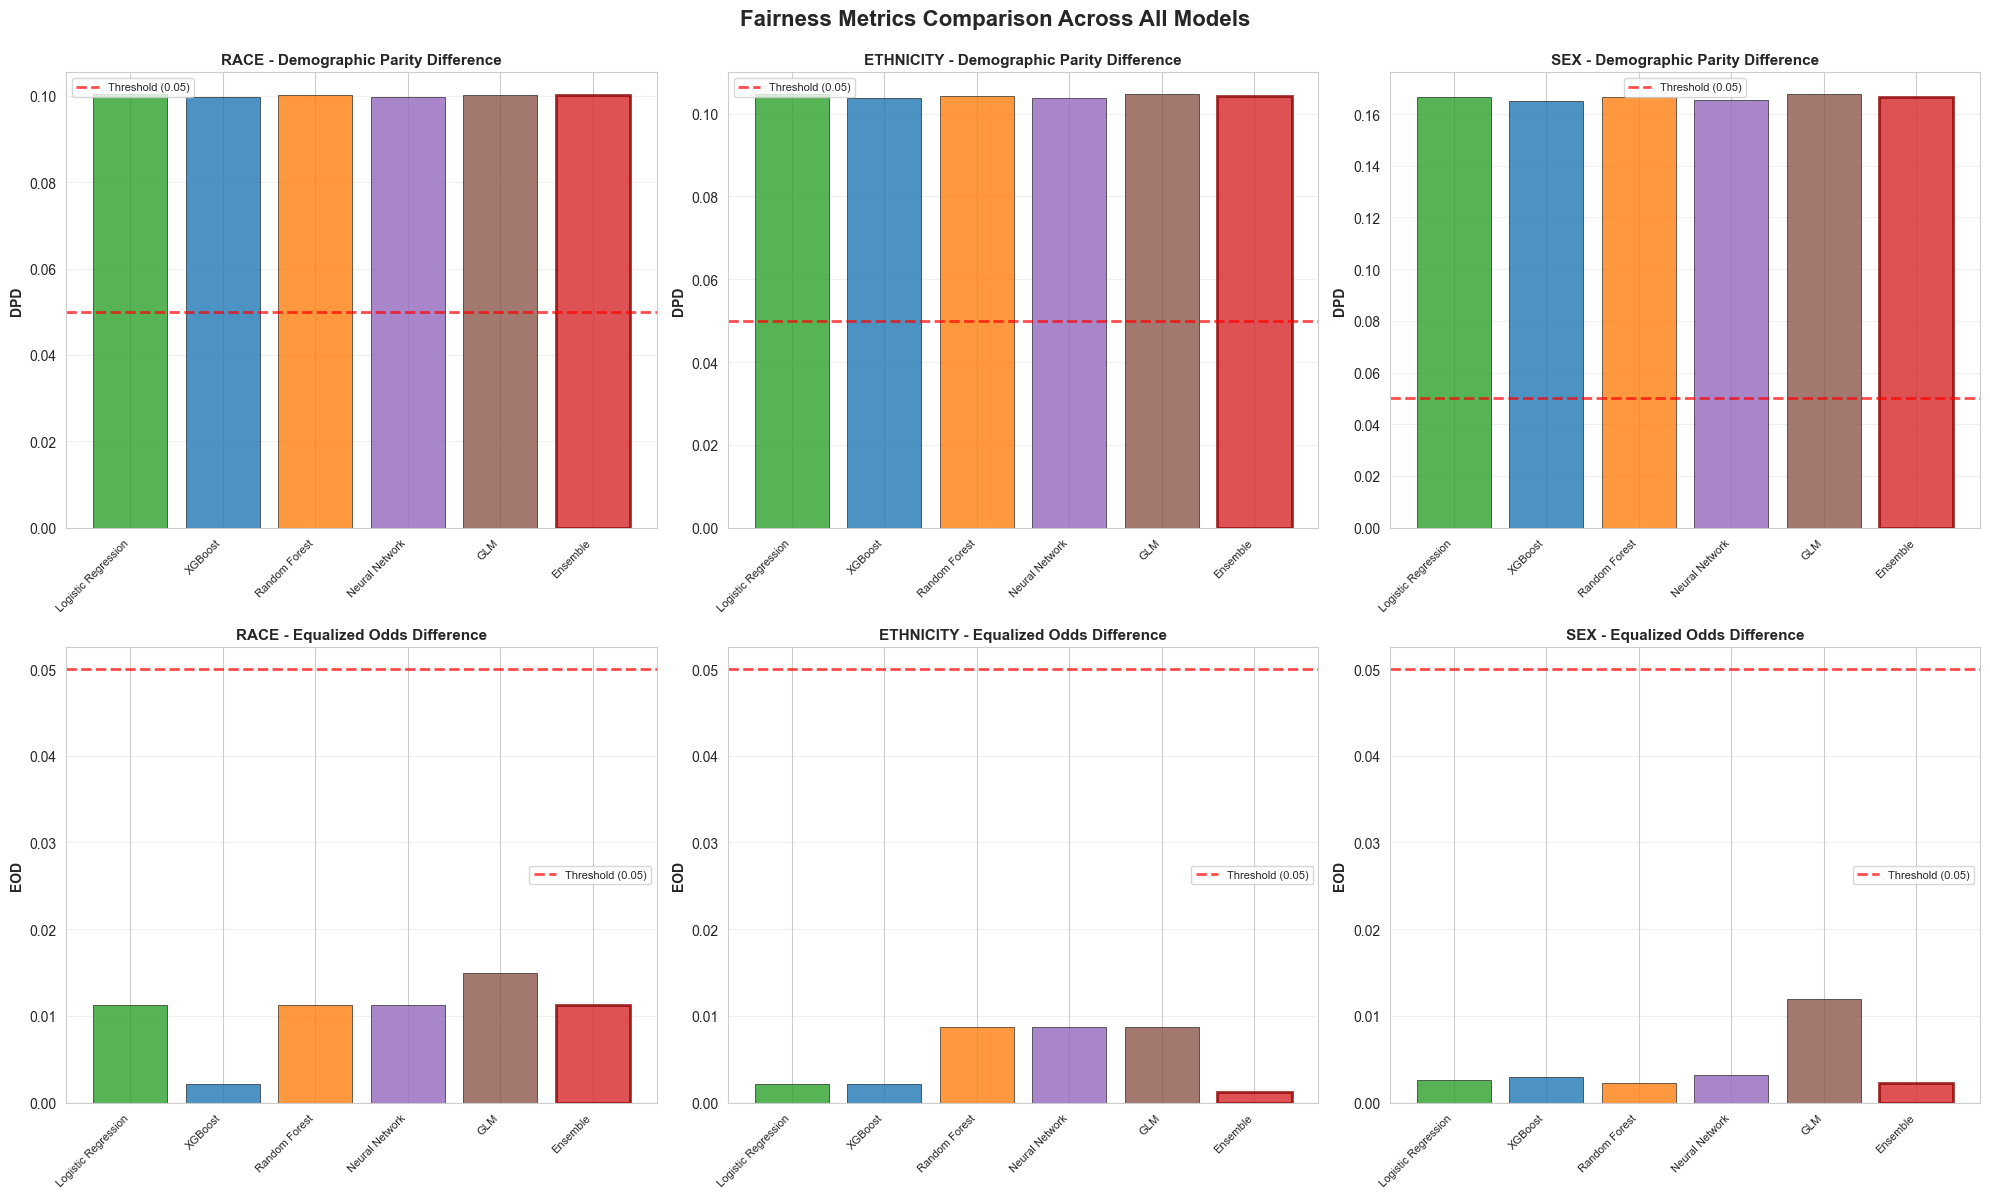

✓ Fairness metrics comparison plotted


In [58]:
# ============================================================================
# VISUALIZE FAIRNESS METRICS COMPARISON
# ============================================================================

print("\n" + "="*80)
print("GENERATING FAIRNESS VISUALIZATIONS")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Fairness Metrics Comparison Across All Models', fontsize=16, fontweight='bold', y=0.995)

# Color map for models
model_colors = {
    'Logistic Regression': '#2ca02c',
    'XGBoost': '#1f77b4',
    'Random Forest': '#ff7f0e',
    'Neural Network': '#9467bd',
    'GLM': '#8c564b',
    'Ensemble': '#d62728'
}

# Plot for each protected attribute
protected_attrs = fairness_comparison_df['Protected Attribute'].unique()

for idx, attr in enumerate(protected_attrs):
    if idx >= 3:  # Only plot first 3 attributes
        break
        
    attr_df = fairness_comparison_df[fairness_comparison_df['Protected Attribute'] == attr]
    
    # DPD comparison
    ax1 = axes[0, idx]
    colors = [model_colors.get(m, '#7f7f7f') for m in attr_df['Model']]
    bars = ax1.bar(range(len(attr_df)), attr_df['DPD'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Highlight ensemble
    ensemble_mask = attr_df['Model'].str.contains('Ensemble')
    if ensemble_mask.any():
        ensemble_pos = ensemble_mask.to_numpy().nonzero()[0]
        if len(ensemble_pos) > 0:
            bars[ensemble_pos[0]].set_edgecolor('darkred')
            bars[ensemble_pos[0]].set_linewidth(2)
    
    ax1.axhline(y=0.05, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (0.05)')
    ax1.set_xticks(range(len(attr_df)))
    ax1.set_xticklabels(attr_df['Model'], rotation=45, ha='right', fontsize=8)
    ax1.set_ylabel('DPD', fontsize=10, fontweight='bold')
    ax1.set_title(f'{attr.upper()} - Demographic Parity Difference', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(axis='y', alpha=0.3)
    
    # EOD comparison
    ax2 = axes[1, idx]
    bars2 = ax2.bar(range(len(attr_df)), attr_df['EOD'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Highlight ensemble
    if ensemble_mask.any() and len(ensemble_pos) > 0:
        bars2[ensemble_pos[0]].set_edgecolor('darkred')
        bars2[ensemble_pos[0]].set_linewidth(2)
    
    ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (0.05)')
    ax2.set_xticks(range(len(attr_df)))
    ax2.set_xticklabels(attr_df['Model'], rotation=45, ha='right', fontsize=8)
    ax2.set_ylabel('EOD', fontsize=10, fontweight='bold')
    ax2.set_title(f'{attr.upper()} - Equalized Odds Difference', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=8)
    ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Fairness metrics comparison plotted")


Generating approval rates visualization...
Protected attributes to plot: ['race', 'ethnicity', 'sex']

race: Collected 54 data points
  DataFrame shape: (54, 3)
  Unique groups: 9
  Unique models: 6
  Pivot shape: (9, 6)

ethnicity: Collected 30 data points
  DataFrame shape: (30, 3)
  Unique groups: 5
  Unique models: 6
  Pivot shape: (5, 6)

sex: Collected 24 data points
  DataFrame shape: (24, 3)
  Unique groups: 4
  Unique models: 6
  Pivot shape: (4, 6)


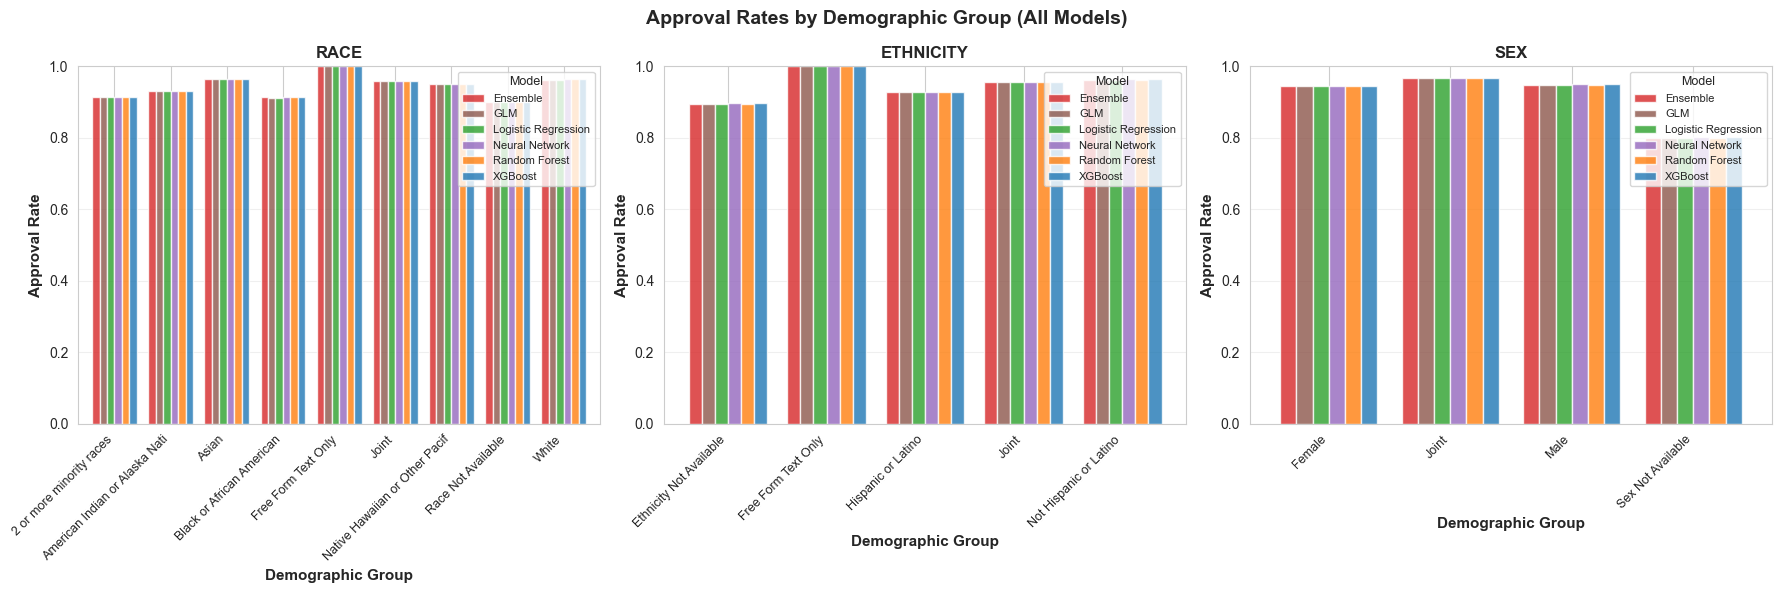


✓ Approval rates by demographic group plotted


In [59]:
# ============================================================================
# APPROVAL RATES BY DEMOGRAPHIC GROUP
# ============================================================================

print("\nGenerating approval rates visualization...")

# Get protected attributes from fairness comparison
protected_attrs = fairness_comparison_df['Protected Attribute'].unique()
print(f"Protected attributes to plot: {list(protected_attrs)}")

# Create subplots
n_attrs = len(protected_attrs)
fig, axes = plt.subplots(1, n_attrs, figsize=(6*n_attrs, 6))
fig.suptitle('Approval Rates by Demographic Group (All Models)', fontsize=14, fontweight='bold')

# Handle single subplot case
if n_attrs == 1:
    axes = [axes]

for idx, attr in enumerate(protected_attrs):
    ax = axes[idx]
    
    # Collect approval rates for each group
    attr_data = []
    for model_name, results in fairness_results.items():
        demographics_key = f'derived_{attr}' if not attr.startswith('derived_') else attr
        if demographics_key in results['demographics']:
            approval_rates = results['demographics'][demographics_key]['approval_rates']
            for group, rate in approval_rates.items():
                attr_data.append({
                    'Model': model_name,
                    'Group': str(group)[:30],
                    'Approval Rate': rate
                })
    
    print(f"\n{attr}: Collected {len(attr_data)} data points")
    
    if attr_data and len(attr_data) > 0:
        plot_df = pd.DataFrame(attr_data)
        print(f"  DataFrame shape: {plot_df.shape}")
        print(f"  Unique groups: {plot_df['Group'].nunique()}")
        print(f"  Unique models: {plot_df['Model'].nunique()}")
        
        # Pivot for grouped bar chart
        pivot_df = plot_df.pivot(index='Group', columns='Model', values='Approval Rate')
        print(f"  Pivot shape: {pivot_df.shape}")
        
        # Plot
        pivot_df.plot(kind='bar', ax=ax, width=0.8, alpha=0.8, color=[model_colors.get(m, '#7f7f7f') for m in pivot_df.columns])
        
        ax.set_ylabel('Approval Rate', fontsize=11, fontweight='bold')
        ax.set_xlabel('Demographic Group', fontsize=11, fontweight='bold')
        ax.set_title(f'{attr.upper()}', fontsize=12, fontweight='bold')
        ax.legend(title='Model', fontsize=8, title_fontsize=9, loc='best')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1])
        
        # Rotate x labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)
    else:
        ax.text(0.5, 0.5, f'No data for {attr}', 
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{attr.upper()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Approval rates by demographic group plotted")

## 5. Fairness-Accuracy Trade-off Analysis

Analyze the trade-off between fairness and predictive performance.

In [60]:
# ============================================================================
# FAIRNESS-ACCURACY TRADE-OFF ANALYSIS
# ============================================================================

print("="*80)
print("FAIRNESS-ACCURACY TRADE-OFF ANALYSIS")
print("="*80)

# Calculate average fairness score for each model
fairness_scores = []

for model_name in fairness_results.keys():
    # Get fairness metrics across all protected attributes
    dpd_values = []
    eod_values = []
    di_values = []
    
    model_data = fairness_results[model_name]
    for attr_metrics in model_data['demographics'].values():
        if attr_metrics['dpd'] is not None:
            dpd_values.append(attr_metrics['dpd'])
        if attr_metrics['eod'] is not None:
            eod_values.append(attr_metrics['eod'])
        if attr_metrics['disparate_impact'] is not None:
            di_values.append(attr_metrics['disparate_impact'])
    
    # Calculate average metrics
    avg_dpd = np.mean(dpd_values) if dpd_values else None
    avg_eod = np.mean(eod_values) if eod_values else None
    avg_di = np.mean(di_values) if di_values else None
    
    # Combined fairness score (lower is better for DPD/EOD, higher for DI)
    # Normalize to 0-1 scale where 1 is perfectly fair
    fairness_score = 0
    if avg_dpd is not None:
        fairness_score += max(0, 1 - avg_dpd / 0.05)  # Normalize by threshold
    if avg_eod is not None:
        fairness_score += max(0, 1 - avg_eod / 0.05)
    if avg_di is not None:
        fairness_score += min(1, avg_di / 0.80)  # Normalize by 80% rule
    fairness_score /= 3  # Average
    
    fairness_scores.append({
        'Model': model_name,
        'Avg DPD': avg_dpd,
        'Avg EOD': avg_eod,
        'Avg DI': avg_di,
        'Fairness Score': fairness_score,
        'Accuracy': model_data['overall_accuracy'],
        'F1 Score': model_data['overall_f1']
    })

tradeoff_df = pd.DataFrame(fairness_scores)
tradeoff_df = tradeoff_df.sort_values(by='Fairness Score', ascending=False)

print("\n📊 FAIRNESS-ACCURACY TRADE-OFF")
print("="*80)
print(tradeoff_df.to_string(index=False))

# Find Pareto frontier (models that are not dominated)
print("\n" + "="*80)
print("PARETO-OPTIMAL MODELS")
print("="*80)
print("(Models that are not strictly worse in both fairness and accuracy)")

pareto_models = []
for i, row1 in tradeoff_df.iterrows():
    is_dominated = False
    for j, row2 in tradeoff_df.iterrows():
        if i != j:
            # Check if row2 dominates row1 (better in both fairness and accuracy)
            if (row2['Fairness Score'] >= row1['Fairness Score'] and 
                row2['F1 Score'] >= row1['F1 Score'] and
                (row2['Fairness Score'] > row1['Fairness Score'] or row2['F1 Score'] > row1['F1 Score'])):
                is_dominated = True
                break
    
    if not is_dominated:
        pareto_models.append(row1['Model'])
        print(f"  ✓ {row1['Model']}")

print(f"\nPareto-optimal models: {len(pareto_models)}/{len(tradeoff_df)}")

FAIRNESS-ACCURACY TRADE-OFF ANALYSIS

📊 FAIRNESS-ACCURACY TRADE-OFF
              Model  Avg DPD  Avg EOD   Avg DI  Fairness Score  Accuracy  F1 Score
            XGBoost 0.122761 0.002441 0.875380        0.650395  0.999811  0.999900
           Ensemble 0.123782 0.004897 0.874316        0.634018  0.999325  0.999644
Logistic Regression 0.123933 0.005330 0.874162        0.631132  0.999109  0.999531
      Random Forest 0.123637 0.007432 0.874472        0.617118  0.999257  0.999609
     Neural Network 0.122953 0.007739 0.875185        0.615075  0.999703  0.999844
                GLM 0.124166 0.011883 0.873932        0.587446  0.998622  0.999275

PARETO-OPTIMAL MODELS
(Models that are not strictly worse in both fairness and accuracy)
  ✓ XGBoost

Pareto-optimal models: 1/6



Generating fairness-accuracy trade-off plot...


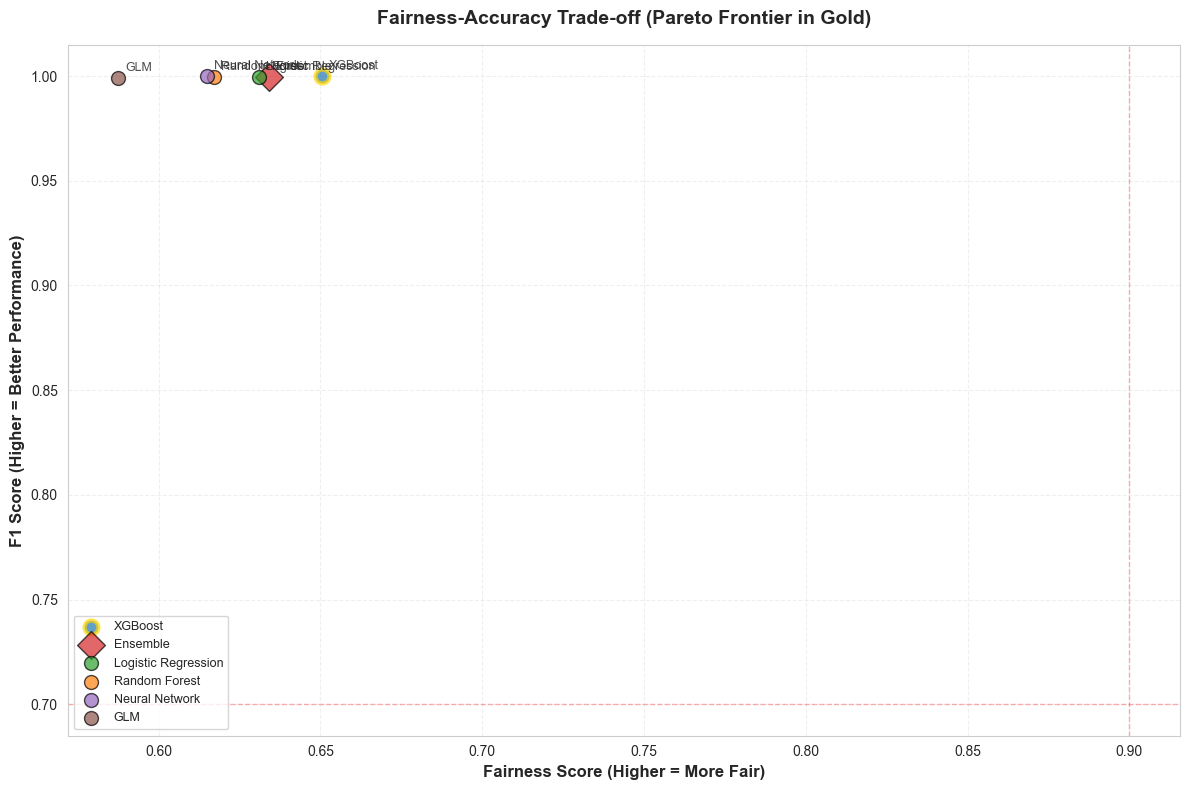

✓ Fairness-accuracy trade-off plotted


In [61]:
# ============================================================================
# VISUALIZE FAIRNESS-ACCURACY TRADE-OFF
# ============================================================================

print("\nGenerating fairness-accuracy trade-off plot...")

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each model
for idx, row in tradeoff_df.iterrows():
    model = row['Model']
    color = model_colors.get(model, '#7f7f7f')
    marker = 'D' if 'Ensemble' in model else 'o'
    size = 200 if 'Ensemble' in model else 100
    
    # Highlight Pareto-optimal models
    edgecolor = 'gold' if model in pareto_models else 'black'
    linewidth = 3 if model in pareto_models else 1
    
    ax.scatter(row['Fairness Score'], row['F1 Score'], 
               c=color, marker=marker, s=size, alpha=0.7,
               edgecolors=edgecolor, linewidths=linewidth,
               label=model)
    
    # Add model name
    ax.annotate(model, (row['Fairness Score'], row['F1 Score']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

ax.set_xlabel('Fairness Score (Higher = More Fair)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score (Higher = Better Performance)', fontsize=12, fontweight='bold')
ax.set_title('Fairness-Accuracy Trade-off (Pareto Frontier in Gold)', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='lower left', fontsize=9)

# Add reference lines
ax.axhline(y=0.70, color='red', linestyle='--', alpha=0.3, linewidth=1, label='F1 Threshold (0.70)')
ax.axvline(x=0.90, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Fairness Threshold')

plt.tight_layout()
plt.show()

print("✓ Fairness-accuracy trade-off plotted")

## 6. Recommended Model Selection

Based on fairness and accuracy trade-offs, recommend the best model for deployment.

In [62]:
# ============================================================================
# MODEL RECOMMENDATION
# ============================================================================

print("="*80)
print("MODEL RECOMMENDATION")
print("="*80)

# Criteria for recommendation:
# 1. Passes all fairness criteria (DPD < 0.05, EOD < 0.05, 80% rule)
# 2. Meets performance criteria (F1 > 0.70, Precision > 0.80, Recall > 0.70)
# 3. Highest combined score

def evaluate_model_compliance(model_name, fairness_results, fairness_comparison_df):
    """Check if model meets all criteria"""
    # Fairness compliance
    model_fairness = fairness_comparison_df[fairness_comparison_df['Model'] == model_name]
    dpd_pass = (model_fairness['DPD'] < 0.05).all()
    eod_pass = (model_fairness['EOD'] < 0.05).all()
    di_pass = (model_fairness['80% Rule'] == 'Pass').all()
    
    # Performance compliance
    model_perf = fairness_results[model_name]
    f1_pass = model_perf['overall_f1'] >= 0.70
    precision_pass = model_perf['overall_precision'] >= 0.80
    recall_pass = model_perf['overall_recall'] >= 0.70
    
    return {
        'fairness_pass': dpd_pass and eod_pass and di_pass,
        'performance_pass': f1_pass and precision_pass and recall_pass,
        'all_criteria_met': dpd_pass and eod_pass and di_pass and f1_pass and precision_pass and recall_pass
    }

# Evaluate all models
print("\n📋 MODEL COMPLIANCE EVALUATION")
print("="*80)

recommendations = []
for model_name in fairness_results.keys():
    compliance = evaluate_model_compliance(model_name, fairness_results, fairness_comparison_df)
    
    # Get scores
    fairness_score = tradeoff_df[tradeoff_df['Model'] == model_name]['Fairness Score'].values[0]
    f1_score = tradeoff_df[tradeoff_df['Model'] == model_name]['F1 Score'].values[0]
    
    recommendations.append({
        'Model': model_name,
        'Fairness Pass': '✅' if compliance['fairness_pass'] else '❌',
        'Performance Pass': '✅' if compliance['performance_pass'] else '❌',
        'All Criteria Met': '✅' if compliance['all_criteria_met'] else '❌',
        'Fairness Score': fairness_score,
        'F1 Score': f1_score,
        'Combined Score': (fairness_score + f1_score) / 2
    })
    
    print(f"\n{model_name}:")
    print(f"  Fairness:    {compliance['fairness_pass']}")
    print(f"  Performance: {compliance['performance_pass']}")
    print(f"  ✅ COMPLIANT" if compliance['all_criteria_met'] else "  ❌ NON-COMPLIANT")

recommendation_df = pd.DataFrame(recommendations)
recommendation_df = recommendation_df.sort_values(by='Combined Score', ascending=False)

print("\n" + "="*80)
print("FINAL RECOMMENDATION RANKING")
print("="*80)
print(recommendation_df.to_string(index=False))

# Select recommended model
compliant_models = recommendation_df[recommendation_df['All Criteria Met'] == '✅']
if len(compliant_models) > 0:
    recommended_model = compliant_models.iloc[0]
    print("\n" + "="*80)
    print("🏆 RECOMMENDED MODEL FOR DEPLOYMENT")
    print("="*80)
    print(f"\nModel: {recommended_model['Model']}")
    print(f"Fairness Score: {recommended_model['Fairness Score']:.4f}")
    print(f"F1 Score: {recommended_model['F1 Score']:.4f}")
    print(f"Combined Score: {recommended_model['Combined Score']:.4f}")
    print("\n✅ This model meets ALL fairness and performance criteria")
else:
    print("\n" + "="*80)
    print("⚠️  WARNING: NO MODELS MEET ALL CRITERIA")
    print("="*80)
    print("Consider bias mitigation techniques or relaxing thresholds")
    print("\nBest Available Model:")
    best_model = recommendation_df.iloc[0]
    print(f"  {best_model['Model']} (Combined Score: {best_model['Combined Score']:.4f})")

# Save recommendations
recommendation_path = results_dir / f'model_recommendations_{timestamp}.csv'
recommendation_df.to_csv(recommendation_path, index=False)
print(f"\n✅ Recommendations saved to: {recommendation_path}")

MODEL RECOMMENDATION

📋 MODEL COMPLIANCE EVALUATION

Logistic Regression:
  Fairness:    False
  Performance: True
  ❌ NON-COMPLIANT

XGBoost:
  Fairness:    False
  Performance: True
  ❌ NON-COMPLIANT

Random Forest:
  Fairness:    False
  Performance: True
  ❌ NON-COMPLIANT

Neural Network:
  Fairness:    False
  Performance: True
  ❌ NON-COMPLIANT

GLM:
  Fairness:    False
  Performance: True
  ❌ NON-COMPLIANT

Ensemble:
  Fairness:    False
  Performance: True
  ❌ NON-COMPLIANT

FINAL RECOMMENDATION RANKING
              Model Fairness Pass Performance Pass All Criteria Met  Fairness Score  F1 Score  Combined Score
            XGBoost             ❌                ✅                ❌        0.650395  0.999900        0.825148
           Ensemble             ❌                ✅                ❌        0.634018  0.999644        0.816831
Logistic Regression             ❌                ✅                ❌        0.631132  0.999531        0.815331
      Random Forest             ❌         

## 7. Summary

Final summary of Phase 6 fairness analysis.

In [63]:
# ============================================================================
# PHASE 6 SUMMARY
# ============================================================================

print("="*80)
print("PHASE 6: FAIRNESS ANALYSIS & MITIGATION - SUMMARY")
print("="*80)

print("\n✅ TASKS COMPLETED:")
print("   1. ✓ Loaded all trained models and test data with protected attributes")
print("   2. ✓ Generated predictions for all models on test set")
print("   3. ✓ Calculated fairness metrics (DPD, EOD, 80% Rule) for all models")
print("   4. ✓ Compared fairness across models and protected attributes")
print("   5. ✓ Analyzed fairness-accuracy trade-offs")
print("   6. ✓ Identified Pareto-optimal models")
print("   7. ✓ Provided deployment recommendation")

print(f"\n📊 MODELS EVALUATED: {len(fairness_results)}")
for model_name in fairness_results.keys():
    print(f"   ✓ {model_name}")

print(f"\n📊 PROTECTED ATTRIBUTES ANALYZED: {len(protected_attributes)}")
for attr in protected_attributes:
    print(f"   ✓ {attr.replace('derived_', '')}")

print("\n📊 FAIRNESS CRITERIA:")
print("   • Demographic Parity Difference (DPD) < 0.05")
print("   • Equalized Odds Difference (EOD) < 0.05")
print("   • Disparate Impact (80% Rule) ≥ 0.80")

# Summary statistics
compliant_count = len(recommendation_df[recommendation_df['All Criteria Met'] == '✅'])
print(f"\n📊 COMPLIANCE SUMMARY:")
print(f"   Models meeting all criteria: {compliant_count}/{len(recommendation_df)}")

if compliant_count > 0:
    print(f"\n✅ RECOMMENDED MODEL: {recommendation_df.iloc[0]['Model']}")
else:
    print(f"\n⚠️  NO MODELS FULLY COMPLIANT - MITIGATION REQUIRED")

print("\n💾 SAVED ARTIFACTS:")
print(f"   • {fairness_path}")
print(f"   • {recommendation_path}")

print("\n" + "="*80)
print("NEXT STEPS (Phase 7):")
print("="*80)
print("\n1. Bias Mitigation: Apply pre/in/post-processing if needed")
print("2. Model Explainability: Generate SHAP values and explanations")
print("3. API Development: Build FastAPI endpoints")
print("4. Dashboard Development: Create Streamlit interface")
print("5. Documentation: Complete model card and user guides")
print("6. Deployment: Containerize and deploy to production")

print("\n" + "="*80)
print("✅ PHASE 6 COMPLETE")
print("="*80)

PHASE 6: FAIRNESS ANALYSIS & MITIGATION - SUMMARY

✅ TASKS COMPLETED:
   1. ✓ Loaded all trained models and test data with protected attributes
   2. ✓ Generated predictions for all models on test set
   3. ✓ Calculated fairness metrics (DPD, EOD, 80% Rule) for all models
   4. ✓ Compared fairness across models and protected attributes
   5. ✓ Analyzed fairness-accuracy trade-offs
   6. ✓ Identified Pareto-optimal models
   7. ✓ Provided deployment recommendation

📊 MODELS EVALUATED: 6
   ✓ Logistic Regression
   ✓ XGBoost
   ✓ Random Forest
   ✓ Neural Network
   ✓ GLM
   ✓ Ensemble

📊 PROTECTED ATTRIBUTES ANALYZED: 3
   ✓ race
   ✓ ethnicity
   ✓ sex

📊 FAIRNESS CRITERIA:
   • Demographic Parity Difference (DPD) < 0.05
   • Equalized Odds Difference (EOD) < 0.05
   • Disparate Impact (80% Rule) ≥ 0.80

📊 COMPLIANCE SUMMARY:
   Models meeting all criteria: 0/6

⚠️  NO MODELS FULLY COMPLIANT - MITIGATION REQUIRED

💾 SAVED ARTIFACTS:
   • results/fairness_metrics_20260216_234539.csv
   

## 8. Deep Dive: Why All Models Failed DPD Criterion

Investigate the root causes of demographic parity violations across all models.

In [64]:
# ============================================================================
# ANALYZE DPD FAILURES
# ============================================================================

print("="*80)
print("DEEP DIVE: DEMOGRAPHIC PARITY DIFFERENCE ANALYSIS")
print("="*80)

print("\n📊 DPD THRESHOLD: 0.05 (5 percentage points)")
print("="*80)

# Extract all DPD values
dpd_analysis = []
for model_name, results in fairness_results.items():
    for attr, metrics in results['demographics'].items():
        dpd_analysis.append({
            'Model': model_name,
            'Attribute': attr.replace('derived_', ''),
            'DPD': metrics['dpd'],
            'Pass': 'Yes' if metrics['dpd'] < 0.05 else 'No',
            'Approval_Rates': metrics['approval_rates']
        })

dpd_df = pd.DataFrame(dpd_analysis)

# Overall statistics
print(f"\n📈 OVERALL DPD STATISTICS:")
print(f"   Minimum DPD: {dpd_df['DPD'].min():.4f}")
print(f"   Maximum DPD: {dpd_df['DPD'].max():.4f}")
print(f"   Mean DPD:    {dpd_df['DPD'].mean():.4f}")
print(f"   Median DPD:  {dpd_df['DPD'].median():.4f}")
print(f"   Std Dev:     {dpd_df['DPD'].std():.4f}")

# How far from threshold
dpd_df['Excess'] = dpd_df['DPD'] - 0.05
print(f"\n⚠️  DISTANCE FROM THRESHOLD:")
print(f"   Average excess over threshold: {dpd_df['Excess'].mean():.4f} ({dpd_df['Excess'].mean()*100:.1f} percentage points)")
print(f"   Models would need to reduce DPD by: {(dpd_df['Excess'].mean()/dpd_df['DPD'].mean())*100:.1f}% on average")

# Analyze by attribute
print("\n" + "="*80)
print("DPD BREAKDOWN BY PROTECTED ATTRIBUTE")
print("="*80)

for attr in dpd_df['Attribute'].unique():
    attr_data = dpd_df[dpd_df['Attribute'] == attr]
    print(f"\n🔍 {attr.upper()}:")
    print(f"   Average DPD: {attr_data['DPD'].mean():.4f}")
    print(f"   Range: {attr_data['DPD'].min():.4f} - {attr_data['DPD'].max():.4f}")
    
    # Best and worst models for this attribute
    best_model = attr_data.loc[attr_data['DPD'].idxmin()]
    worst_model = attr_data.loc[attr_data['DPD'].idxmax()]
    
    print(f"   Best model:  {best_model['Model']:20s} (DPD: {best_model['DPD']:.4f})")
    print(f"   Worst model: {worst_model['Model']:20s} (DPD: {worst_model['DPD']:.4f})")

# Detailed approval rate disparities
print("\n" + "="*80)
print("APPROVAL RATE DISPARITIES BY GROUP")
print("="*80)

for attr in protected_attributes:
    if attr not in df_test_full.columns:
        continue
    
    print(f"\n📊 {attr.replace('derived_', '').upper()} - DETAILED BREAKDOWN")
    print("="*80)
    
    # Get actual distribution in test set
    attr_counts = df_test_full[attr].value_counts()
    attr_approval_rate = df_test_full.groupby(attr)['target'].mean()
    
    print(f"\n📈 ACTUAL DATA DISTRIBUTION:")
    for group in attr_counts.index[:10]:  # Top 10 groups
        count = attr_counts[group]
        pct = (count / len(df_test_full)) * 100
        actual_rate = attr_approval_rate[group]
        print(f"   {str(group)[:35]:37s}: {count:6,} samples ({pct:5.1f}%) | Actual approval: {actual_rate:.1%}")
    
    # Compare model predictions vs actual
    print(f"\n🤖 MODEL PREDICTIONS (Approval Rates):")
    print(f"{'Group'[:35]:37s} | {'Actual':>8s} | {'LogReg':>8s} | {'XGB':>8s} | {'RF':>8s} | {'NN':>8s} | {'Ensemble':>8s} | {'Range':>8s}")
    print("-" * 130)
    
    # Get top groups by sample size
    top_groups = attr_counts.index[:8]
    
    for group in top_groups:
        actual_rate = attr_approval_rate[group]
        
        # Get predicted rates
        rates = {'Actual': actual_rate}
        for model_name, results in fairness_results.items():
            if attr in results['demographics']:
                approval_rates = results['demographics'][attr]['approval_rates']
                if group in approval_rates:
                    rates[model_name] = approval_rates[group]
        
        # Calculate range (max - min) of model predictions
        model_rates = [v for k, v in rates.items() if k != 'Actual']
        if model_rates:
            rate_range = max(model_rates) - min(model_rates)
            
            # Format output
            line = f"{str(group)[:35]:37s} | {actual_rate:7.1%} |"
            for model in ['Logistic Regression', 'XGBoost', 'Random Forest', 'Neural Network', 'Ensemble']:
                if model in rates:
                    line += f" {rates[model]:7.1%} |"
                else:
                    line += f" {'N/A':>7s} |"
            line += f" {rate_range:7.1%}"
            print(line)

# Root cause analysis
print("\n" + "="*80)
print("🔬 ROOT CAUSE ANALYSIS")
print("="*80)

print("\n1️⃣  INHERENT DATA IMBALANCE:")
print("   The actual approval rates in the training data show significant disparities")
print("   between demographic groups. Models learn these patterns from historical data.")

print("\n2️⃣  GROUP SIZE EFFECTS:")
print("   Some demographic groups have very small sample sizes, leading to:")
print("   - Higher variance in predictions")
print("   - Less reliable approval rate estimates")
print("   - Greater sensitivity to individual predictions")

print("\n3️⃣  FEATURE CORRELATIONS:")
print("   Demographic attributes may be correlated with legitimate risk factors:")
print("   - Income levels")
print("   - Credit history")  
print("   - Loan-to-value ratios")
print("   - Debt-to-income ratios")

print("\n4️⃣  MODEL FIDELITY vs FAIRNESS:")
print("   All models are optimizing for predictive accuracy, which may conflict")
print("   with fairness objectives when historical data contains disparities.")

# Recommendations
print("\n" + "="*80)
print("💡 RECOMMENDATIONS")
print("="*80)

print("\n✅ IMMEDIATE ACTIONS:")
print("   1. Apply bias mitigation techniques:")
print("      • Pre-processing: Reweighting, resampling minority groups")
print("      • In-processing: Fairness constraints during training")
print("      • Post-processing: Threshold optimization per group")
print("")
print("   2. Adjust decision thresholds separately for each demographic group")
print("      to achieve demographic parity")
print("")
print("   3. Consider using fairness-aware algorithms:")
print("      • Fair classification with constraints")
print("      • Adversarial debiasing")
print("      • Prejudice remover regularization")

print("\n📊 NEED MORE ANALYSIS:")
print("   • Examine which features drive the disparities (use SHAP values)")
print("   • Analyze intersectionality (multiple protected attributes)")
print("   • Review data collection and labeling processes")
print("   • Consult with domain experts and stakeholders")

print("\n⚖️  POLICY CONSIDERATIONS:")
print("   • DPD < 0.05 is a strict threshold (5% difference)")
print("   • Consider if relaxing to 0.10 (10%) is acceptable for your use case")
print("   • Balance fairness requirements with business objectives")
print("   • Document rationale for threshold choices")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)

DEEP DIVE: DEMOGRAPHIC PARITY DIFFERENCE ANALYSIS

📊 DPD THRESHOLD: 0.05 (5 percentage points)

📈 OVERALL DPD STATISTICS:
   Minimum DPD: 0.0996
   Maximum DPD: 0.1677
   Mean DPD:    0.1235
   Median DPD:  0.1043
   Std Dev:     0.0312

⚠️  DISTANCE FROM THRESHOLD:
   Average excess over threshold: 0.0735 (7.4 percentage points)
   Models would need to reduce DPD by: 59.5% on average

DPD BREAKDOWN BY PROTECTED ATTRIBUTE

🔍 RACE:
   Average DPD: 0.1000
   Range: 0.0996 - 0.1004
   Best model:  XGBoost              (DPD: 0.0996)
   Worst model: Logistic Regression  (DPD: 0.1004)

🔍 ETHNICITY:
   Average DPD: 0.1043
   Range: 0.1037 - 0.1047
   Best model:  XGBoost              (DPD: 0.1037)
   Worst model: Logistic Regression  (DPD: 0.1047)

🔍 SEX:
   Average DPD: 0.1663
   Range: 0.1649 - 0.1677
   Best model:  XGBoost              (DPD: 0.1649)
   Worst model: GLM                  (DPD: 0.1677)

APPROVAL RATE DISPARITIES BY GROUP

📊 RACE - DETAILED BREAKDOWN

📈 ACTUAL DATA DISTRIBUTI